In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt
import celerite2.theano as celerite2
from celerite2.theano import terms
import exoplanet as xo

import starspot as ss
import starspot.stitch as sps

# Stitching TESS light curves with a GP.

First, I load a file which has the times of the sector beginnings and ends. This is a hack -- I think there's a better way to get hold of the TESS orbit times! Also, I'm loading a multi-sector TESS light curve that I made earlier using So Hattori's CPM code.

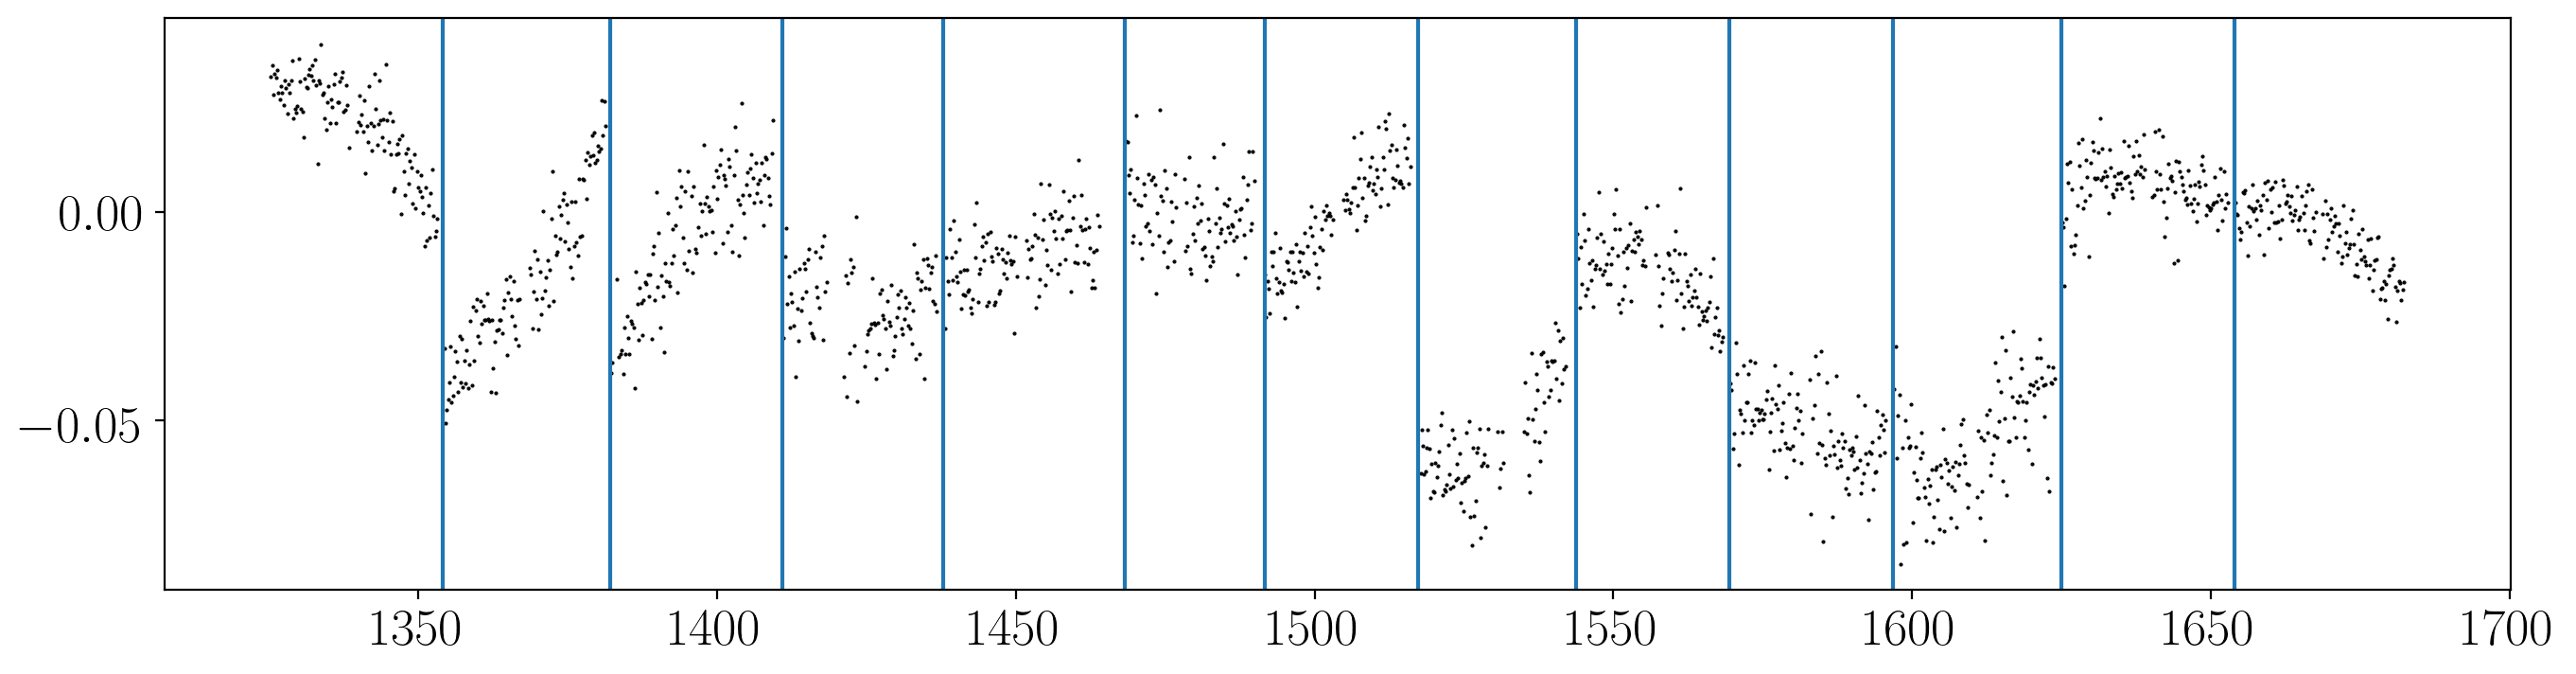

In [2]:
sector_times = pd.read_csv("sector_times.csv")
sample_lc = pd.read_csv("sample_lc.csv")
x, y, yerr = sample_lc.time.values, sample_lc.flux.values, sample_lc.flux_err.values

plt.figure(figsize=(16, 4), dpi=200)
plt.plot(x, y, "k.", ms=1)

m = (sector_times.event == "start")
starts = sector_times.TJD.values[m]
for t in starts[1:]:
    plt.axvline(t)
gap_times = starts[1:]

Now I define functions I'll need to model an offset for each sector, plus a GP to fit the stellar variability. step_model is the 

In [3]:
def step_model(t, gap_times, steps):
    """
    The step model. A model that starts at zero for the 1st light curve, then
    models the offsets between subsequent light curves and the 1st.

    Args:
        t (array): The concatenated time array of all light curves.
        gap_times (array): The times of the gaps between light curves.
        steps (array): The flux differences between the 1st light curve, and
            all following light curves.

    Returns:
        mu (array): A model that is zero for the 1st light curve, with step
            functions for the offsets of all subsequent light curves.

    """
    mu = np.zeros(len(t))
    if len(gap_times) > 1:
        for i in range(len(gap_times)-1):
            mu += (t >= gap_times[i]) * (t < gap_times[i+1]) * steps[i]
        mu += (t >= gap_times[-1]) * steps[-1]
    else:
        mu = (t >= gap_times) * steps
    return mu


def model_offsets(t, y, yerr, stdev, steps):
    """
    Define the PyMC3 GP offset model.

    """

    nsteps = len(steps)
    stdevs = np.ones(nsteps)*stdev
    with pm.Model() as model:

        # Parameters
        sigma = pm.Normal("sigma", mu=1., sd=100.0)
        rho = pm.Normal("rho", mu=1., sd=100.0)

        # Define step parameters
        step_params = pm.Normal("step_params", mu=steps, sd=stdevs, shape=nsteps)

        # The step model
        mu = step_model(t, gap_times, step_params)

        # Set up the kernel an GP
        kernel = terms.Matern32Term(sigma=sigma, rho=rho)
        gp = celerite2.GaussianProcess(kernel, t, yerr=yerr)

        # Add a custom "potential" (log probability function) with the GP
        # likelihood
        pm.Potential("gp", gp.log_likelihood(y - mu))

    return model, gp


def find_optimum(model):
    """
    Optimize to find the MAP solution.
    
    Args:
        model: the PyMC3 model from model_offsets.

    Returns:
        map_soln (dict): a dictionary containing the optimized parameters.
    """

    with model:
        map_soln = xo.optimize(start=model.test_point)

    return map_soln


def evaluate_model(test_t, model, gp, map_soln):
    """
    Evaluate the best-fit GP offset model.

    Args:
        test_t (array): The ordinate values to plot the prediction at.

    Returns:
        mu (array): The best-fit mean-function.
        var (array): The variance of the model
    """

    with model:
        mu, var = xo.eval_in_model(
            gp.predict(test_t, return_var=True), map_soln)
    return mu, var

Define parameters and make sure the flux array, 'y' is in the right format.

In [4]:
steps = np.zeros(len(gap_times))
y = np.ascontiguousarray(y, dtype=np.float64)
stdev = 2.0

Define the model.

In [5]:
mod, gp = model_offsets(x, y, yerr, stdev, steps)

Optimize.

In [ ]:
map_soln = find_optimum(mod)

Create the stitched light curve.

In [ ]:
stitched = y - step_model(x, gap_times, map_soln["step_params"])

Substract a straight line from the stitched light curve to straighten it out.

In [ ]:
w = np.polyfit(x, stitched, 1)
stitched -= np.polyval(w, x)

Plot the stitched light curve on top of the original.

In [ ]:
plt.figure(figsize=(16, 6), dpi=200)

plt.plot(x, y, "C0.", alpha=.5, zorder=1, label="Original")
plt.errorbar(x, stitched, yerr=yerr, fmt="k.", alpha=.5, zorder=0, label="Stitched")
plt.legend()

plt.xlabel("Time")
plt.ylabel("Flux");